In [1]:

# https://stackoverflow.com/a/61931785/20972261
# First of all remove all your regularizers and dropout.
# Reduce the number of units in your LSTM. Reach a point where your model stops overfitting.
# Then, add dropout if required.
# After that, the next step is to add the tf.keras.Bidirectional. If still, you are not satfisfied then, increase number of layers. Remember to keep return_sequences True for every LSTM layer except the last one.
# It is seldom I come across networks using layer regularization despite the availability because dropout and layer regularization have a same effect and people usually go with dropout (at maximum, I have seen 0.3 being used).

from constants import target_name, x_path, y_path, preprocessed_data
from libs.simple_processing import separate_target, normalize
import pandas as pd

# data = pd.read_csv(preprocessed_data, usecols=[3], engine='python')
data = pd.read_csv(preprocessed_data, engine='python')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   month_number   1609124 non-null  int64
 1   shop_id        1609124 non-null  int64
 2   item_id        1609124 non-null  int64
 3   monthly_sales  1609124 non-null  int64
dtypes: int64(4)
memory usage: 49.1 MB


    month_number  monthly_sales
0              0             15
1              1             22
2              2             38
3              3             30
4              4             21
5              5             25
6              6             18
7              7             20
8              8             27
9              9             14
10            10             30
11            11             47
12            12             48
13            13             38
14            14             43
15            15             35
16            16             55
17            17             50
18            18             41
19            19             37
20            20             43
21            21             45
22            22             62
23            23             77
24            24             67
25            25             54
26            26             74
27            27             34
28            28             34
29            29             20
30      

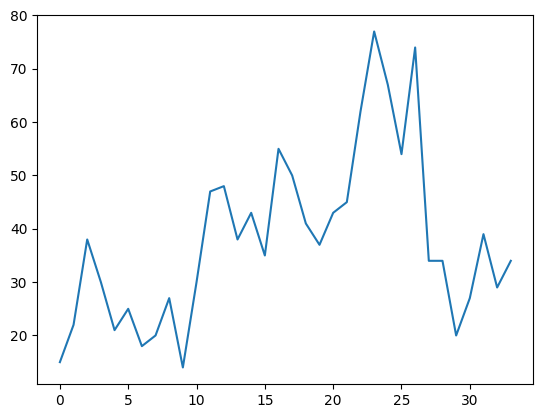

In [6]:

# Looks like the shop id is much better option - it is used almost 100K times
# Let's validate by drawing a global sales history for that shop and item

from pandas import DataFrame
import matplotlib.pyplot as plt

shop_id = 31#shops_frequent.index[0]
item_id = 5822#items_frequent.index[0] 22166

by_shop = data.query(f'shop_id=={shop_id} and item_id=={item_id}')
sales_shop = by_shop.groupby(['month_number'], as_index=False)['monthly_sales'].sum()

print(sales_shop)

fig, ax = plt.subplots()
ax.plot(sales_shop.month_number, sales_shop.monthly_sales)

In [65]:
import numpy as np

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    # print(dataset)
    dataX, dataY = [], []
    for curri in range(len(dataset)-look_back-1):
        nexti = curri + look_back
        # print(nexti)
        dataX.append(dataset[curri : nexti])
        dataY.append(dataset[nexti : nexti + 1])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 2
X, y = create_dataset(sales_shop.monthly_sales, look_back)

# print('X: ', X, 'y: ', y)
# print(pd.DataFrame([X, y]))

# reshape input to be: [samples, time steps, features]
# print(X.shape)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
# print('X shape: ', X.shape)
# print('X: ', X)
# print('type of X: ', type(X))
# print('----')
# print('----')
# print(y.shape)
# y = np.reshape(y, (y.shape[0], 1, y.shape[1]))
# print(y.shape)
# print(y[-1:])

print(X[-1:])
print(X.shape)


[[[27 39]]]
(31, 1, 2)


Epoch 1/500


2023-01-10 11:04:09.557779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 11:04:09.774151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 11:04:09.904294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 12ms/step - loss: 39.1362 - mean_absolute_error: 39.1362
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 38.5755 - mean_absolute_error: 38.5755
Epoch 3/500
31/31 [==============================] - 0s 13ms/step - loss: 38.1072 - mean_absolute_error: 38.1072
Epoch 4/500
31/31 [==============================] - 0s 16ms/step - loss: 37.5262 - mean_absolute_error: 37.5262
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 36.8447 - mean_absolute_error: 36.8447
Epoch 6/500
31/31 [==============================] - 0s 11ms/step - loss: 36.3104 - mean_absolute_error: 36.3104
Epoch 7/500
31/31 [==============================] - 0s 13ms/step - loss: 35.2748 - mean_absolute_error: 35.2748
Epoch 8/500
31/31 [==============================] - 0s 12ms/step - loss: 34.6508 - mean_absolute_error: 34.6508
Epoch 9/500
31/31 [==============================] - 0s 12ms/step - loss: 34.1115 - mean_absolute_error: 34.1

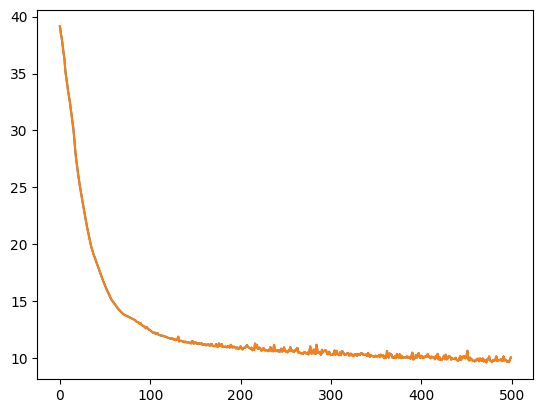

In [54]:
import tensorflow as tf
from libs.simple_plotter import plot_history

X_train = X.copy()
y_train = y.copy()

# features_count = X_train.shape[0]

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.1,    # minimium amount of change to count as an improvement
    patience=7,         # how many epochs to wait before stopping
    restore_best_weights=True
)

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, input_shape=(1, look_back), return_sequences=False))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam()
              , loss=tf.keras.losses.MeanAbsoluteError()
              , metrics=tf.metrics.MeanAbsoluteError())

history = model.fit(X_train, y_train
                    , epochs=500
                    , callbacks=[early_stopping]
                    , batch_size = 1
                    , use_multiprocessing=True)

# print(history.history)
plot_history(history)


1/1 [==============================] - 0s 347ms/step


2023-01-10 11:08:49.455970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-10 11:08:49.537211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<class 'numpy.ndarray'>
[[28.387745]
 [41.41204 ]
 [30.735558]
 [25.043102]
 [29.960163]
 [23.433891]
 [25.597912]
 [32.38149 ]
 [21.953335]
 [36.764645]
 [45.15715 ]
 [43.75812 ]
 [35.663372]
 [42.203278]
 [34.18229 ]
 [47.393124]
 [43.556404]
 [37.861065]
 [36.650883]
 [42.367535]
 [42.626667]
 [48.501026]
 [49.950344]
 [47.835697]
 [43.598843]
 [49.81153 ]
 [32.11756 ]
 [35.67927 ]
 [24.725563]
 [32.38149 ]
 [41.3509  ]]


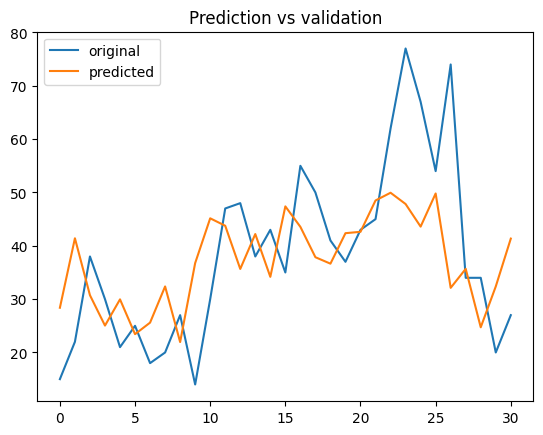

<Figure size 4000x1500 with 0 Axes>

In [55]:
from libs.simple_plotter import plot_predictions

y_pred = model.predict(X_train)
print(type(y_pred))
print(y_pred)
scale = range(len(y_pred))
plt.plot(scale, sales_shop.monthly_sales[:len(y_pred)], label="original")
plt.plot(scale, y_pred, label="predicted")
plt.title("Prediction vs validation")
plt.legend()
fig = plt.figure(figsize=(40, 15))

# pętla robiąca predykcję na kilka m-cy w przód

# lookback > 1
# wykres obrazujacy przewidywanie przyszłości
# dane sprxedaźowe tygodniowe zamiast mcznychd

last:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 55ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 19ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 26ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 21ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 29ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 31ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 29ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 26ms/step
np:  [[[38 38]]]
last:  [38 38]
1/1 [==============================] - 0s 29ms/step
np:  [[[38 38]]]


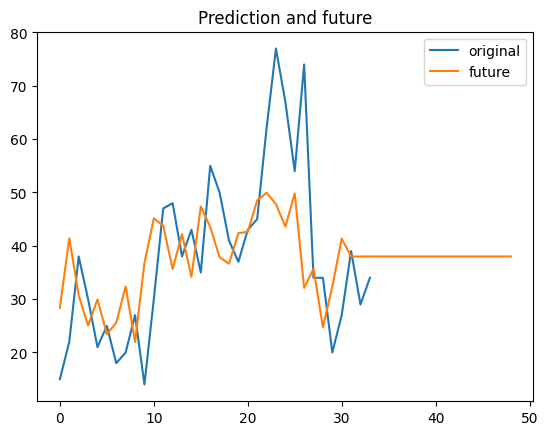

<Figure size 5000x2500 with 0 Axes>

In [85]:
import numpy as np

# last =  [[[27, 39]]]
last =  X_train[-1:]
print('last: ', last)

# X_train.shape
# last.shape
# last
pred = y_pred.copy()

# y_pred

for i in range(1, 10):
    print('last: ', last[0][0])
    new = model.predict(last)
    # np = np.ndarray(last)
    arr = last.copy()
    arr[0][0][0] = arr[0][0][1]
    arr[0][0][1] = new
    print('np: ', arr)

    # obiekt numpy z okreslonym shapem

    pred = np.append(pred, arr)
    last = arr # (27, 29) => (29, new)
#
scale = range(len(sales_shop.monthly_sales))
scale1 = range(len(pred))
plt.plot(scale, sales_shop.monthly_sales[:len(sales_shop.monthly_sales)], label="original")
plt.plot(scale1, pred, label="future")
plt.title("Prediction and future")
plt.legend()
fig = plt.figure(figsize=(50, 25))
